In [1]:
import pandas as pd

df = pd.read_csv('data/trial1.csv', index_col='time')

df = df.iloc[400:500]

# maybe should be done as some kind of moving average
bpm = df['bpm'].mean()

df.head()

,bpm,spo2,Trans: Wave,Reflect: Red,Reflect: IR
time,,,,,
15.992755,67,97,43,1996855,2267239
16.033409,67,97,43,1996889,2267214
16.074053,67,97,43,1996803,2267129
16.112555,67,97,43,1996886,2267239
16.153195,67,97,42,1996931,2267276


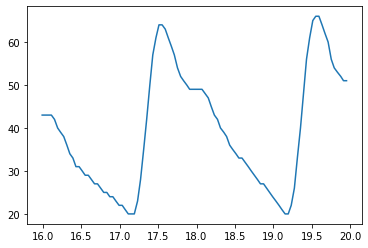

In [2]:
import matplotlib.pyplot as plt

plt.plot(df['Trans: Wave']);

Text(0.5, 0, 'time (s)')

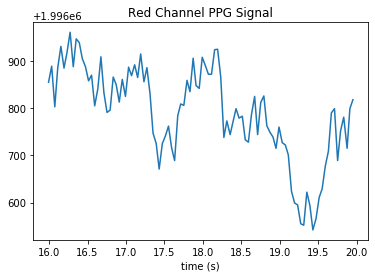

In [3]:
plt.plot(df['Reflect: Red']);
plt.title('Red Channel PPG Signal')
plt.xlabel('time (s)')

Text(0.5, 0, 'time (s)')

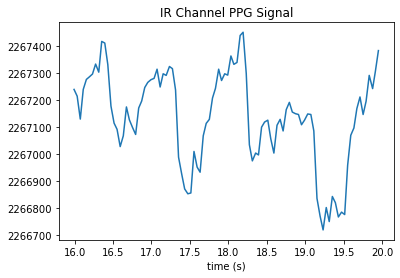

In [4]:
plt.plot(df['Reflect: IR']);
plt.title('IR Channel PPG Signal')
plt.xlabel('time (s)')

In [5]:
samples = len(df.index)
time = (df.index[-1] - df.index[0])
sr = 25

# **Method 1:** Find HeartRate using time interval from peak detection

First, filter before analysis --  here we just a simple butterworth bandpass

In [6]:
# bandpass filter

import heartpy as hp
# sampling at 50Hz, but averaging every 2 samples together for a single output, and so sampling rate is effectively 25 hz?
##### import heartpy as hp
filtered_red = hp.filter_signal(df['Reflect: Red'], 
                                  cutoff = [.7, 4], 
                                  filtertype = 'bandpass',
                                  sample_rate = 25, 
                                  order = 4,
                                  return_top = False)

filtered_ir = hp.filter_signal(df['Reflect: IR'],
                              cutoff = [.7, 4],
                              filtertype = 'bandpass',
                              sample_rate = 25,
                              order = 4,
                              return_top = False)

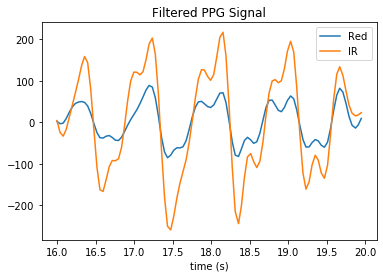

In [7]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(df.index, filtered_red)
plt.plot(df.index, filtered_ir)
plt.title('Filtered PPG Signal')
plt.xlabel('time (s)')
plt.legend(['Red', 'IR']);

### IR Analysis

[52.84858703613281, 55.157275199889924, 52.74626255035422]
measured bpm: 52.74626255035422, real bpm: 67.58


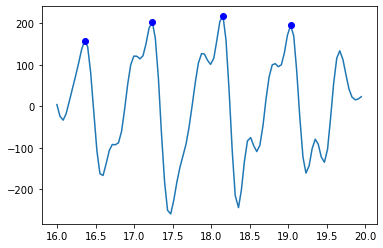

In [8]:
from scipy import signal
import numpy as np

# doesn't give result I want when putting asa param for find_peaks -- not really sure why
width = 60 / bpm

dt = time / samples
dist = width / dt
# give room for error
dist -= .1 * dist

ir = filtered_ir
inv_ir = -ir
peak_idx, _ = signal.find_peaks(ir, distance=dist)

plt.plot(df.index, ir);
plt.plot(df.index[peak_idx], ir[peak_idx], 'bo')

periods = []
for i in range(len(peak_idx) - 1):
    period = df.index[peak_idx[i + 1]] - df.index[peak_idx[i]]
    periods.append(period)
    
print(list(map(lambda x: x * 60, periods)))
avg_period = sum(periods) / len(periods)
print(f'measured bpm: {period * 60}, real bpm: {bpm}')

## Red Analysis

[52.61359691619852, 57.69674777984598, 52.74626255035422, 38.33599090576172]
measured bpm: 38.33599090576172, real bpm: 67.58


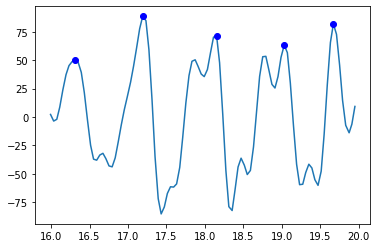

In [9]:
from scipy import signal
import numpy as np

# doesn't give result I want when putting asa param for find_peaks -- not really sure why
width = 60 / bpm

dt = time / samples
dist = width / dt
# give room for error
dist -= .3 * dist

red = filtered_red
inv_red = -red
peak_idx, _ = signal.find_peaks(red, distance=dist)

plt.plot(df.index, red);
plt.plot(df.index[peak_idx], red[peak_idx], 'bo')

periods = []
for i in range(len(peak_idx) - 1):
    period = df.index[peak_idx[i + 1]] - df.index[peak_idx[i]]
    periods.append(period)
    
print(list(map(lambda x: x * 60, periods)))
avg_period = sum(periods) / len(periods)
print(f'measured bpm: {period * 60}, real bpm: {bpm}')

Conclusion: Not great

# **Method 2:** FFT

### IR Analysis

In [10]:
import numpy as np
from scipy import fft

# wf for waveform - should prob use interpolation to ensure equal spacing between samples, but in this case its neglibile
# I mean-subtract just so DC 0-freq component doesn't dominate
wf = df['Reflect: IR'] - df['Reflect: IR'].mean()

C:\Users\micha\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\fft\_pocketfft\helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x, copy=not x.flags['ALIGNED'])
C:\Users\micha\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


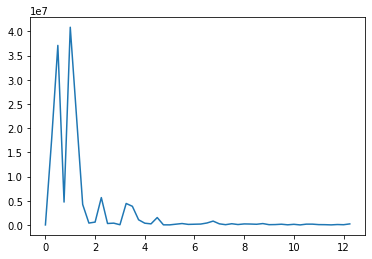

In [11]:
# fourier transform
fhat = fft.fft(wf)
PSD = (fhat * np.conj(fhat))
freq = fft.fftfreq(samples, 1 / sr)

# let's just consider positive freq's
pos_freq = freq[freq >= 0]
pos_PSD = PSD[freq >= 0]

plt.plot(pos_freq, pos_PSD);

In [12]:
hr = pos_freq[np.argmax(pos_PSD)]
hr * 60

60.0

### Red Analysis

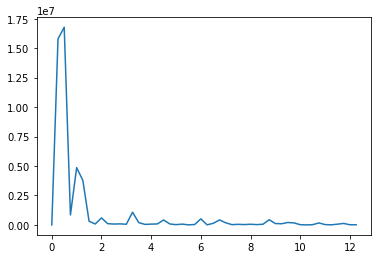

In [13]:
wf = df['Reflect: Red'] - df['Reflect: Red'].mean()

fhat = fft.fft(wf)
PSD = (fhat * np.conj(fhat))
freq = fft.fftfreq(samples, 1/sr)

pos_freq = freq[freq >= 0]
pos_PSD = PSD[freq >= 0]

plt.plot(pos_freq, pos_PSD);

In [14]:
hr = pos_freq[np.argmax(pos_PSD)]
hr * 60

30.0

# Method 3: heartpy's algorithm

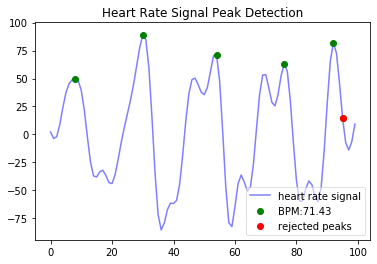

error: 0.05694837864118722


In [15]:
import heartpy as hp

wd_red, m_red = hp.process(filtered_red, sample_rate = sr)
hp.plotter(wd_red, m_red)
bpm_test = m_red['bpm']
error = (bpm_test - bpm) / bpm
print(f'error: {error}')

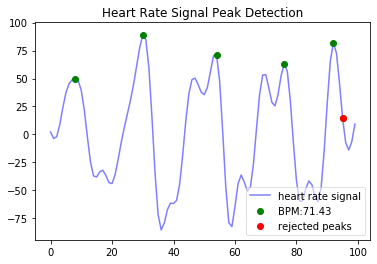

error: 0.05694837864118722


In [16]:
wd_red, m_red = hp.process(filtered_red, sample_rate = sr)
hp.plotter(wd_red, m_red)
bpm_test = m_red['bpm']
error = (bpm_test - bpm) / bpm
print(f'error: {error}')